# Accuracy Study: 

This is a study of how accurate the model is. I'm going to play with dropout, and the number of lstm nodes too see what sort of impact that has.
Afterward, I'll play with different values of maxlen, and look at differences in accuracy with and without the key signature information.

1. Make a training set and a test set.
2. Construct and train the net

### Make a training set and a test set

In [39]:
from data_preprocessing import preprocess_notes_as_array
from data_preprocessing import array_is_nan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Since I don't have much data, I'm going to ignore the key signatures
keysig = False
# Get the preprocessed data
df = preprocess_notes_as_array(keysig = keysig)
# Convert the dataframe into an array
data_array = df.values
# Reshape the data into a single array
data_array = data_array.reshape(1,data_array.size)[0]
print('data length = {}'.format(len(data_array)))
# Identify all of the (nan, nan) entries
index = np.argwhere(array_is_nan(data_array))
# Convert the corpus into a list and delete the (nan,nan) entries
corpus = np.ndarray.tolist(np.delete(data_array, index))

notes = sorted(list(set(corpus)))
print('corpus length:', len(corpus))
print('total notes:', len(notes))
note_indices = dict((n, i) for i, n in enumerate(notes))
indices_note = dict((i, n) for i, n in enumerate(notes))

# The length of phrases to consider.
maxlen=10

print('Complete.')

data length = 8600
corpus length: 4693
total notes: 102
Complete.


In [40]:
# function to cut a set in to semi-redundant sequences of maxlen notes and produce indicator vectors out of the phrases
def cut_vec_corpus(corpus, maxlen = 10, step = 3):
    phrases = []
    next_notes = []
    for i in range(0, len(corpus) - maxlen, step):
        phrases.append(corpus[i: i + maxlen])
        next_notes.append(corpus[i + maxlen])
    #print('nb sequences:', len(phrases))
    x = np.zeros((len(phrases), maxlen, len(notes)), dtype=np.bool)
    y = np.zeros((len(phrases), len(notes)), dtype=np.bool)
    for i, phrase in enumerate(phrases):
        for t, note in enumerate(phrase):
            x[i, t, note_indices[note]] = 1
        y[i, note_indices[next_notes[i]]] = 1
    return x,y

def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

a = [1,2,3]
b = [4,5,6]
shuffle_in_unison(a,b)
print('a:',a)
print('b:',b)


a: [2, 3, 1]
b: [5, 6, 4]


In [49]:
x,y = cut_vec_corpus(corpus)
shuffle_in_unison(x,y)
print(len(x))

k = 100
train_set_x = x[k:]
train_set_y = y[k:]
print('train_set size = {}'.format(len(train_set_x)))
test_set_x = x[:k]
test_set_y = y[:k]
print('test_set size = {}'.format(len(test_set_x)))

print('Complete.')

1561
train_set size = 1461
test_set size = 100
Complete.


## Try some models

In [50]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

# build the model: a single LSTM with 128 nodes
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(notes))))
model.add(Dense(len(notes)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
print('Complete.')

Build model...
Complete.


In [51]:
num_epochs_trained = 0
train_loss = []
test_loss = []

In [52]:
model.metrics_names

['loss']

Epoch 1/1
1461/1461 [==============================] - 2s - loss: 2.8844     
test_loss = 3.306931495666504
Epoch 1/1
1461/1461 [==============================] - 1s - loss: 2.6641     
test_loss = 3.2284698486328125
Epoch 1/1
1461/1461 [==============================] - 1s - loss: 2.4970     
test_loss = 3.315009117126465
Epoch 1/1
1461/1461 [==============================] - 1s - loss: 2.3298     
test_loss = 3.5295379161834717
Epoch 1/1
1461/1461 [==============================] - 1s - loss: 2.2061     
test_loss = 3.7458584308624268
Total number of epochs trained = 10


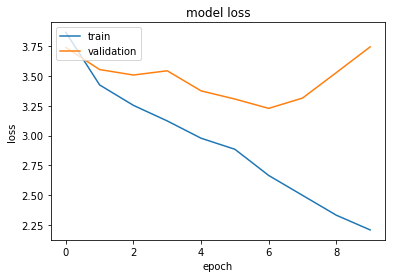

In [54]:
# train the model several epochs, and test on the test set. Plot the loss for train and test sets
for _ in np.arange(5): 
    history = model.fit(train_set_x, train_set_y, batch_size=128, epochs=1)
    train_loss.append(history.history['loss'])
    test_loss.append(model.test_on_batch(test_set_x, test_set_y, sample_weight=None))
    print('test_loss = {}'.format(test_loss[-1]))
    num_epochs_trained = num_epochs_trained + 1
print('Total number of epochs trained = {}'.format(num_epochs_trained))


plt.plot(train_loss)
plt.plot(test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Somehow once I got the following result:
Using lstm with 128 nodes, after 100 epochs, we have a loss of 0.00177 on the test set and 0.0023 on the train set. Overfitting doens't seem to be an issue. I'm wondering if the nature of the data is important: semi reduncant phrases...not sure.

Now I seem to overfit like crazy! Is it possible that I picked a lucky test set? Maybe mixing up test and training sets would be good?

Next I'll try lstm with 32 nodes.

In [55]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

# build the model: a single LSTM with only 32 nodes
print('Build model...')
model = Sequential()
model.add(LSTM(32, input_shape=(maxlen, len(notes))))
model.add(Dense(len(notes)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
print('Complete.')



Build model...
Complete.


In [56]:
num_epochs_trained = 0
train_loss = []
test_loss = []

Epoch 1/1
1461/1461 [==============================] - 0s - loss: 2.6641     
test_loss = 3.3526647090911865
Total number of epochs trained = 10


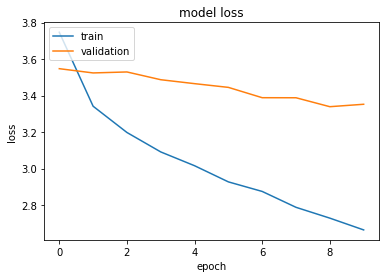

In [66]:
# train the model several epochs, and test on the test set. Plot the loss for train and test sets
for _ in np.arange(1): 
    history = model.fit(train_set_x, train_set_y, batch_size=128, epochs=1)
    train_loss.append(history.history['loss'])
    test_loss.append(model.test_on_batch(test_set_x, test_set_y, sample_weight=None))
    print('test_loss = {}'.format(test_loss[-1]))
    num_epochs_trained = num_epochs_trained + 1
print('Total number of epochs trained = {}'.format(num_epochs_trained))


plt.plot(train_loss)
plt.plot(test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

That magic result comment: After 100 epochs, the errors are ten times higher than with 128 nodes. Next I'll try 128 nodes with dropout before the dense layer. Not that overfitting really seems to be an issue...but I'm curious about when the impact will be.

In [67]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
import keras.layers

# build the model: a single LSTM with 128 nodes and dropout
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(notes))))
keras.layers.Dropout(0.5)
model.add(Dense(len(notes)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
print('Complete.')

Build model...
Complete.


In [68]:
num_epochs_trained = 0
train_loss = []
test_loss = []

Epoch 1/1
1461/1461 [==============================] - 2s - loss: 0.0258     
test_loss = 6.013129711151123
Epoch 1/1
1461/1461 [==============================] - 1s - loss: 0.1528     
test_loss = 5.969188690185547
Epoch 1/1
1461/1461 [==============================] - 1s - loss: 0.0313     
test_loss = 6.221703052520752
Epoch 1/1
1461/1461 [==============================] - 1s - loss: 0.0499     
test_loss = 6.05919075012207
Epoch 1/1
1461/1461 [==============================] - 1s - loss: 0.0177     
test_loss = 6.378222465515137
Epoch 1/1
1461/1461 [==============================] - 1s - loss: 0.0222     
test_loss = 6.543333530426025
Epoch 1/1
1461/1461 [==============================] - 1s - loss: 0.1626     
test_loss = 6.215706825256348
Epoch 1/1
1461/1461 [==============================] - 1s - loss: 0.0197     
test_loss = 6.118327617645264
Epoch 1/1
1461/1461 [==============================] - 1s - loss: 0.0171     
test_loss = 6.252157688140869
Epoch 1/1
1461/1461 [========

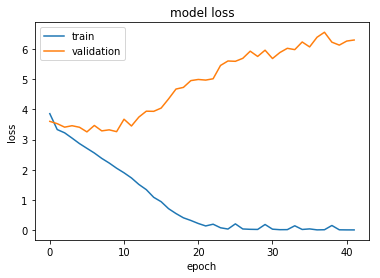

In [70]:
# train the model several epochs, and test on the test set. Plot the loss for train and test sets
for _ in np.arange(10): 
    history = model.fit(train_set_x, train_set_y, batch_size=128, epochs=1)
    train_loss.append(history.history['loss'])
    test_loss.append(model.test_on_batch(test_set_x, test_set_y, sample_weight=None))
    print('test_loss = {}'.format(test_loss[-1]))
    num_epochs_trained = num_epochs_trained + 1
print('Total number of epochs trained = {}'.format(num_epochs_trained))


plt.plot(train_loss)
plt.plot(test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

That magic result: A bit better results here. The loss is slightly lower, and the jumps in the loss are smaller, which is nice. So I like the dropout, what if I take even more lstm nodes? Like 256 of them...

In [71]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
import keras.layers

# build the model: a single LSTM with 256 nodes
print('Build model...')
model = Sequential()
model.add(LSTM(256, input_shape=(maxlen, len(notes))))
keras.layers.Dropout(0.5)
model.add(Dense(len(notes)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
print('Complete.')

Build model...
Complete.


In [72]:
num_epochs_trained = 0
train_loss = []
test_loss = []

Epoch 1/1
1461/1461 [==============================] - 9s - loss: 4.0532     
test_loss = 3.6565990447998047
Epoch 1/1
1461/1461 [==============================] - 3s - loss: 3.4141     
test_loss = 3.6463053226470947
Epoch 1/1
1461/1461 [==============================] - 3s - loss: 3.3792     
test_loss = 3.5194547176361084
Epoch 1/1
1461/1461 [==============================] - 3s - loss: 3.2462     
test_loss = 3.474670648574829
Epoch 1/1
1461/1461 [==============================] - 2s - loss: 3.1148     
test_loss = 3.379361152648926
Epoch 1/1
1461/1461 [==============================] - 2s - loss: 2.9164     
test_loss = 3.356372356414795
Epoch 1/1
1461/1461 [==============================] - 2s - loss: 2.7316     
test_loss = 3.252079963684082
Epoch 1/1
1461/1461 [==============================] - 2s - loss: 2.5522     
test_loss = 3.2166945934295654
Epoch 1/1
1461/1461 [==============================] - 2s - loss: 2.4222     
test_loss = 3.3065967559814453
Epoch 1/1
1461/1461 [==

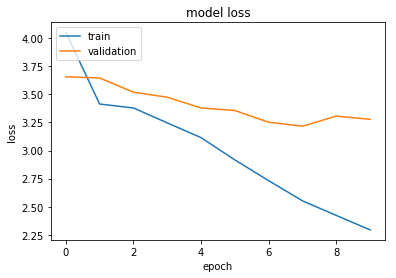

In [73]:
# train the model several epochs, and test on the test set. Plot the loss for train and test sets
for _ in np.arange(10): 
    history = model.fit(train_set_x, train_set_y, batch_size=128, epochs=1)
    train_loss.append(history.history['loss'])
    test_loss.append(model.test_on_batch(test_set_x, test_set_y, sample_weight=None))
    print('test_loss = {}'.format(test_loss[-1]))
    num_epochs_trained = num_epochs_trained + 1
print('Total number of epochs trained = {}'.format(num_epochs_trained))


plt.plot(train_loss)
plt.plot(test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Magic result: This gives similar results to 128 with dropout.

# Playing with other parameters

Take the best model, but include the key signature information.

In [77]:
# Set up the data again
from data_preprocessing import preprocess_notes_as_array
from data_preprocessing import array_is_nan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Include the key signature information this time
keysig = True
# Get the preprocessed data
df = preprocess_notes_as_array(keysig = keysig)
# Convert the dataframe into an array
data_array = df.values
# Reshape the data into a single array
data_array = data_array.reshape(1,data_array.size)[0]
# Identify all of the (nan, nan) entries
index = np.argwhere(array_is_nan(data_array))
# Convert the corpus into a list and delete the (nan,nan) entries
corpus = np.ndarray.tolist(np.delete(data_array, index))

notes = sorted(list(set(corpus)))
print('total notes:', len(notes))
note_indices = dict((n, i) for i, n in enumerate(notes))
indices_note = dict((i, n) for i, n in enumerate(notes))

# The length of phrases to consider.
maxlen=10

print('Complete.')

total notes: 393
Complete.


In [78]:
x,y = cut_vec_corpus(corpus)
shuffle_in_unison(x,y)

k = 100
train_set_x = x[k:]
train_set_y = y[k:]
print('train_set size = {}'.format(len(train_set_x)))
test_set_x = x[:k]
test_set_y = y[:k]
print('test_set size = {}'.format(len(test_set_x)))

print('Complete.')

train_set size = 1461
test_set size = 100
Complete.


In [79]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
import keras.layers

# build the model: a single LSTM with 128 nodes and dropout
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(notes))))
keras.layers.Dropout(0.5)
model.add(Dense(len(notes)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
print('Complete.')

Build model...
Complete.


In [80]:
num_epochs_trained = 0
train_loss = []
test_loss = []

Epoch 1/1
1461/1461 [==============================] - 7s - loss: 5.1103     
test_loss = 4.265522480010986
Epoch 1/1
1461/1461 [==============================] - 3s - loss: 3.9466     
test_loss = 3.7901294231414795
Epoch 1/1
1461/1461 [==============================] - 2s - loss: 3.6469     
test_loss = 3.609550714492798
Epoch 1/1
1461/1461 [==============================] - 2s - loss: 3.4120     
test_loss = 3.611567735671997
Epoch 1/1
1461/1461 [==============================] - 1s - loss: 3.2226     
test_loss = 3.827341318130493
Epoch 1/1
1461/1461 [==============================] - 2s - loss: 3.1054     
test_loss = 3.471345901489258
Epoch 1/1
1461/1461 [==============================] - 1s - loss: 2.8869     
test_loss = 3.5267505645751953
Epoch 1/1
1461/1461 [==============================] - 1s - loss: 2.6955     
test_loss = 3.4715182781219482
Epoch 1/1
1461/1461 [==============================] - 1s - loss: 2.4750     
test_loss = 3.5251500606536865
Epoch 1/1
1461/1461 [===

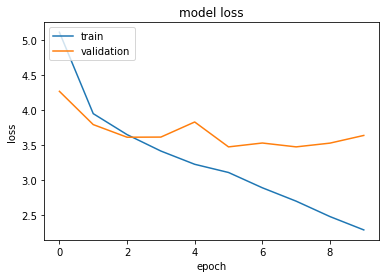

In [81]:
# train the model several epochs, and test on the test set. Plot the loss for train and test sets
for _ in np.arange(10): 
    history = model.fit(train_set_x, train_set_y, batch_size=128, epochs=1)
    train_loss.append(history.history['loss'])
    test_loss.append(model.test_on_batch(test_set_x, test_set_y, sample_weight=None))
    print('test_loss = {}'.format(test_loss[-1]))
    num_epochs_trained = num_epochs_trained + 1
print('Total number of epochs trained = {}'.format(num_epochs_trained))


plt.plot(train_loss)
plt.plot(test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Terrible overfitting with key signature information included!!!

## Different values of maxlen

Try maxlen = 40, and keysig = False
Try maxlen = 5, keysig = False

In [82]:
from data_preprocessing import preprocess_notes_as_array
from data_preprocessing import array_is_nan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Since I don't have much data, I'm going to ignore the key signatures
keysig = False
# Get the preprocessed data
df = preprocess_notes_as_array(keysig = keysig)
# Convert the dataframe into an array
data_array = df.values
# Reshape the data into a single array
data_array = data_array.reshape(1,data_array.size)[0]
# Identify all of the (nan, nan) entries
index = np.argwhere(array_is_nan(data_array))
# Convert the corpus into a list and delete the (nan,nan) entries
corpus = np.ndarray.tolist(np.delete(data_array, index))

notes = sorted(list(set(corpus)))
print('total notes:', len(notes))
note_indices = dict((n, i) for i, n in enumerate(notes))
indices_note = dict((i, n) for i, n in enumerate(notes))

# The length of phrases to consider.
maxlen=10

print('Complete.')

total notes: 102
Complete.


In [89]:

x,y = cut_vec_corpus(corpus, maxlen = maxlen)
shuffle_in_unison(x,y)
print(len(x))

k = 10
train_set_x = x[k:]
train_set_y = y[k:]
print('train_set size = {}'.format(len(train_set_x)))
test_set_x = x[:k]
test_set_y = y[:k]
print('test_set size = {}'.format(len(test_set_x)))

print('Complete.')

1561
train_set size = 1551
test_set size = 10
Complete.


In [99]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
import keras.layers

# build the model: a single LSTM with 128 nodes and dropout
print('Build model...')
model = Sequential()
model.add(LSTM(10, input_shape=(maxlen, len(notes))))
keras.layers.Dropout(0.5)
model.add(Dense(len(notes)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
print('Complete.')

Build model...
Complete.


In [100]:

num_epochs_trained = 0
train_loss = []
test_loss = []
print('Initialized.')

Initialized.


Epoch 1/1
1551/1551 [==============================] - 2s - loss: 2.5551     
test_loss = 2.5318000316619873
Epoch 1/1
1551/1551 [==============================] - 1s - loss: 2.5069     
test_loss = 2.658658027648926
Epoch 1/1
1551/1551 [==============================] - 1s - loss: 2.4610     
test_loss = 2.60502552986145
Epoch 1/1
1551/1551 [==============================] - 1s - loss: 2.4091     
test_loss = 2.8082478046417236
Epoch 1/1
1551/1551 [==============================] - 1s - loss: 2.3755     
test_loss = 2.8135790824890137
Epoch 1/1
1551/1551 [==============================] - 1s - loss: 2.3335     
test_loss = 2.8239517211914062
Epoch 1/1
1551/1551 [==============================] - 1s - loss: 2.3013     
test_loss = 2.7909340858459473
Epoch 1/1
1551/1551 [==============================] - 1s - loss: 2.2614     - ETA:
test_loss = 2.787174940109253
Epoch 1/1
1551/1551 [==============================] - 1s - loss: 2.2350     - E
test_loss = 2.9282491207122803
Epoch 1/1
1551

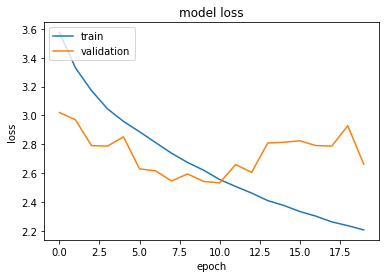

In [104]:
# train the model several epochs, and test on the test set. Plot the loss for train and test sets
for _ in np.arange(10): 
    history = model.fit(train_set_x, train_set_y, batch_size=20, epochs=1)
    train_loss.append(history.history['loss'])
    test_loss.append(model.test_on_batch(test_set_x, test_set_y, sample_weight=None))
    print('test_loss = {}'.format(test_loss[-1]))
    num_epochs_trained = num_epochs_trained + 1
print('Total number of epochs trained = {}'.format(num_epochs_trained))


plt.plot(train_loss)
plt.plot(test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()